# Analyzing aperiodic activity in resting state data with spectral parameterization


### Aperiodic activity has largely been ignored, and the focus has been on oscillatory activity

So, how do we derive aperiodic activity in resting state data (including sleep). EEG is a very popular imaging method since its relatively cheap. Thus, this notebook will showcast how to analyze EEG resting state data.

In this notebook, we show an example of how you can compare aperiodic measurements from 2 different people. One diagnosed with PD, and another age-matched healthy control. During this the notebook will show how you can inspect model fits of a single power spectrum. Then, we will continue analyzing all patients and healthy controls in a for loop for demonstrative purposes. The notebook will be finished with performing statistics to establish whether the aperiodic exponent is significantly altered in patients with PD from healthy controls. 

* DISCLAIMER #1: this is not a clinical investigation, the puspose of this notebook is to show how to use the spectral parameterization toolbox on resting-state (scalp-EEG) data. 
* DISCLAIMER #2: the data is not preprocessed, which means no filtering has been applied, nor ICA has been used to delete muscle artifacts. Therefore, results should NOT be interpreted on a theoretical level.

### Spectral parameterization

This technique differentiates oscillatory activity from aperiodic activity. In this notebook, we only focus on extracting the aperiodic exponent, which we believe reflects the E/I balance in the brain (cortex when measuring EEG). 
[Donoghue, Haller, Peterson et al., 2020](https://www.nature.com/articles/s41593-020-00744-x)

### Related Work

The following papers include discussion of this topic:

- [Helson et al., 2023](https://www.nature.com/articles/s41531-023-00553-6)

The data used in this notebook comes from:

[UCSD resting state in parkinson EEG](https://openneuro.org/datasets/ds002778/versions/1.0.5)

These are the citations corresponding to the data:

Nicko Jackson, Scott R. Cole, Bradley Voytek, Nicole C. Swann. Characteristics of Waveform Shape in Parkinson's Disease Detected with Scalp Electroencephalography. eNeuro 20 May 2019, 6 (3) ENEURO.0151-19.2019; DOI: 10.1523/ENEURO.0151-19.2019.

Swann NC, de Hemptinne C, Aron AR, Ostrem JL, Knight RT, Starr PA. Elevated synchrony in Parkinson disease detected with electroencephalography. Ann Neurol. 2015 Nov;78(5):742-50. doi: 10.1002/ana.24507. Epub 2015 Sep 2. PMID: 26290353; PMCID: PMC4623949.

George JS, Strunk J, Mak-McCully R, Houser M, Poizner H, Aron AR. Dopaminergic therapy in Parkinson's disease decreases cortical beta band coherence in the resting state and increases cortical beta band power during executive control. Neuroimage Clin. 2013 Aug 8;3:261-70. doi: 10.1016/j.nicl.2013.07.013. PMID: 24273711; PMCID: PMC3814961.

Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A. and Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software 4: (1896).

Pernet, C. R., Appelhoff, S., Gorgolewski, K. J., Flandin, G.,
Phillips, C., Delorme, A., Oostenveld, R. (2019). EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Scientific Data, 6, 103. https://doi.org/10.1038/s41597-019-0104-8.



### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

## Step 0: Importing libraries, and setting settings

In [1]:
# Imports - general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from neurodsp.utils import set_random_seed

# For plotting time series and power spectras, also computing power spectra
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

# For computing and plotting a time-frequency plot
from neurodsp.timefrequency import compute_wavelet_transform
from neurodsp.plts import plot_timefrequency

# Importing the spectral parameterization tools
from fooof import FOOOF, FOOOFGroup

# Import mne to load data
import mne


# I don't think I use any of the below ones
# from neurodsp.sim import sim_powerlaw, sim_random_walk, sim_oscillation, sim_bursty_oscillation
# from neurodsp.sim import sim_combined 
# from neurodsp.sim import sim_peak_oscillation <-- pip install upgrade once this version is released
# from neurodsp.timefrequency import amp_by_time, phase_by_time
# from neurodsp.sim.utils import rotate_timeseries


# from neurodsp.utils import create_times



/Users/quirine/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/quirine/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Settings

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Set whether to save out figures
SAVE_FIG = False

In [6]:
# Settings for spectral parameterization
SETS_FOOOF = {'peak_width_limits': [2, 8], 'min_peak_height': 0.2} 
FREQ_RANGE = [2, 40] # might need to change this based on what comes next

# A. Process data for sample patient with age-matched control

## Step 1: Import data

This includes extracting the sampling frequency, and doing a basic band-pass filter (since the data was not preprocessed)

OLD

Shape of data is 3 rows and n time points.

1st row = pd data 

2nd row = hc data 

3rd row = time data 

sampling frequency = 512 Hz


In [7]:
# Paths pointing to data (on a local laptop)
data_path = '/Users/quirine/Documents/Projects/parkinson_rest/DATA/'
sub_pd = 'sub-pd9/ses-off/eeg/sub-pd9_ses-off_task-rest_eeg.bdf'
sub_hc = 'sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf'

# Load data
data_pd = mne.io.read_raw_bdf(data_path + sub_pd, preload=True)
data_hc = mne.io.read_raw_bdf(data_path + sub_hc, preload=True)

Extracting EDF parameters from /Users/quirine/Documents/Projects/parkinson_rest/DATA/sub-pd9/ses-off/eeg/sub-pd9_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
Extracting EDF parameters from /Users/quirine/Documents/Projects/parkinson_rest/DATA/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...


In [8]:
data_pd.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2011-03-07 12:42:33 UTC
 nchan: 41
 projs: []
 sfreq: 512.0 Hz
>

In [9]:
FS = int(data_pd.info['sfreq']) # 512 Hz

In [10]:
# Since data was not preprocessed, let's just quickly filter it in the frequency range of 1-40 Hz;
# Which is an interpretable range for EEG
data_pd.filter(l_freq=1, h_freq=40)
data_hc.filter(l_freq=1, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

<RawEDF | sub-hc7_ses-hc_task-rest_eeg.bdf, 41 x 98304 (192.0 s), ~30.8 MB, data loaded>

In [11]:
# For simplicity, we'll only be looking into 1 electrode. But you may expand on this in your own research
pd_cz = data_pd.get_data(picks='Cz').squeeze()
pd_time = data_pd.times

hc_cz = data_hc.get_data(picks='Cz').squeeze()
hc_time = data_hc.times

# # C
# # combine into 1 array to import into new notebook:
# hc_cz = hc_cz[:len(pd_time)] # make sure they are the same length
# # concatenate with time-axis
# data = np.vstack((pd_cz, hc_cz, pd_time))

## Step 2: Visuzalize the data in time-domain

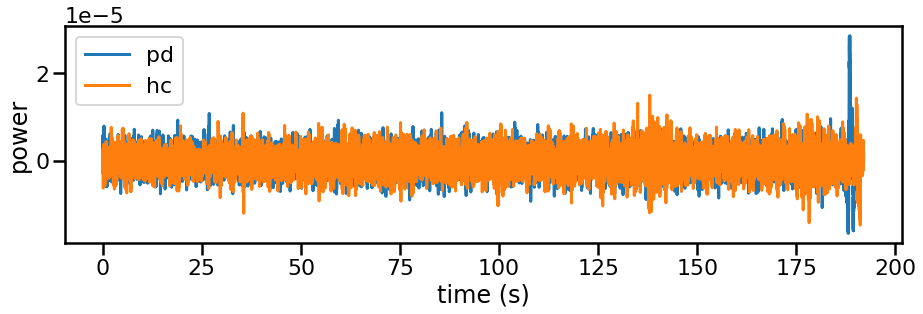

In [12]:
# plot time series
plt.figure(figsize=(15,4))

plt.plot(pd_time, pd_cz, label='pd')
plt.plot(hc_time, hc_cz, label='hc')
plt.xlabel('time (s)')
plt.ylabel('power')
plt.legend()
plt.show()

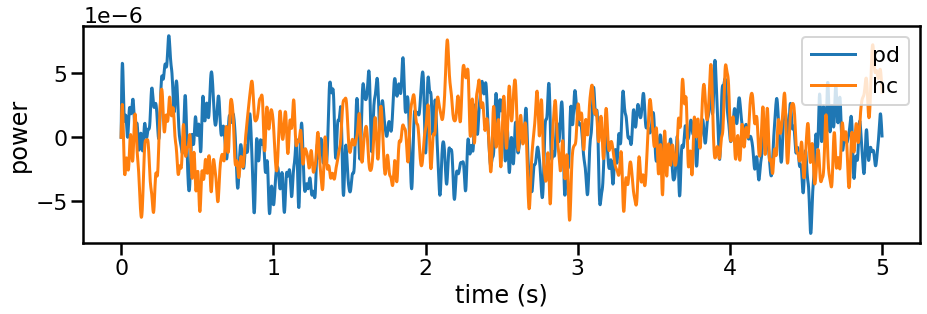

In [13]:
# plot time series for only 5 seconds
plt.figure(figsize=(15,4))

plt.plot(pd_time[:FS*5], pd_cz[:FS*5], label='pd')
plt.plot(hc_time[:FS*5], hc_cz[:FS*5], label='hc')
plt.xlabel('time (s)')
plt.ylabel('power')
plt.legend()
plt.show()

Clearly some artifact is happening towards the end of the recording for the PD patient. Therefore, we should probably not include that for calculating our PSD which will be the next step. For fairness if we want to compare both participants, we should have the same length in time anyway. So, let's just say we will cut the length to include **175 seconds**

In [14]:
# Cut signal to only include 175 seconds
sec = 175
pd_cz_cut = pd_cz[:FS*sec]
pd_time_cut = pd_time[:FS*sec]
hc_cz_cut = hc_cz[:FS*sec]
hc_time_cut = hc_time[:FS*sec]

## Step 3: Create power spectra + visualize power spectra

In [15]:
# First we need to create a power spectrum
# with 4 second windows and 2 second of overlap, in the frequency range of how the data was filtered
freqs, pd_psd = compute_spectrum(pd_cz_cut, fs=FS, nperseg=FS*4, noverlap=FS*2, f_range=[1,40])
freqs, hc_psd = compute_spectrum(hc_cz_cut, fs=FS, nperseg=FS*4, noverlap=FS*2, f_range=[1,40])

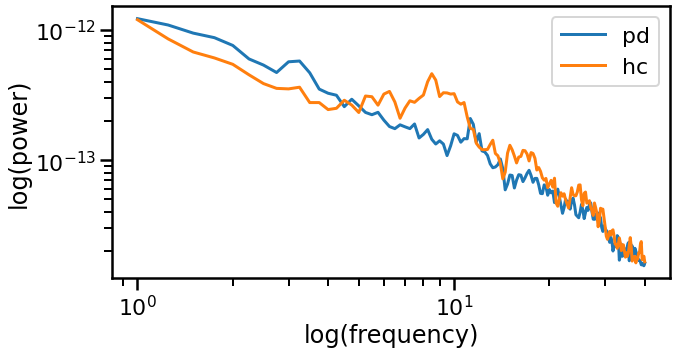

In [16]:
# Plot the power spectra
plt.figure(figsize=(10,5))
plt.loglog(freqs, pd_psd, label='pd')
plt.loglog(freqs, hc_psd, label='hc')
plt.legend()
plt.xlabel('log(frequency)')
plt.ylabel('log(power)')
plt.show()

Visually, what do you observe in these power spectra? Do they look different to the naked eye?

## Step 4: Apply spectral parameterization to power spectra

In [17]:
# Create model
pd_model = FOOOF(**SETS_FOOOF)
hc_model = FOOOF(**SETS_FOOOF)

# fit model
pd_model.fit(freqs, pd_psd, freq_range=FREQ_RANGE)
hc_model.fit(freqs, hc_psd, freq_range=FREQ_RANGE)

Now we can inspect the model fit based on the r_squared value, and visually

In [18]:
# inspect model fit of pd person
pd_model.print_settings(description=True)
print('r-squared: \t', pd_model.r_squared_)

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [2, 8]                                    
                        Limits for minimum and maximum peak widths, in Hz.                        
                                    Max Number of Peaks : inf                                     
                          Maximum number of peaks that can be extracted.                          
                                    Minimum Peak Height : 0.2                                     
                Minimum absolute height of a peak, above the aperiodic component.                 
                                       Peak Threshold: 2.0                                        
          

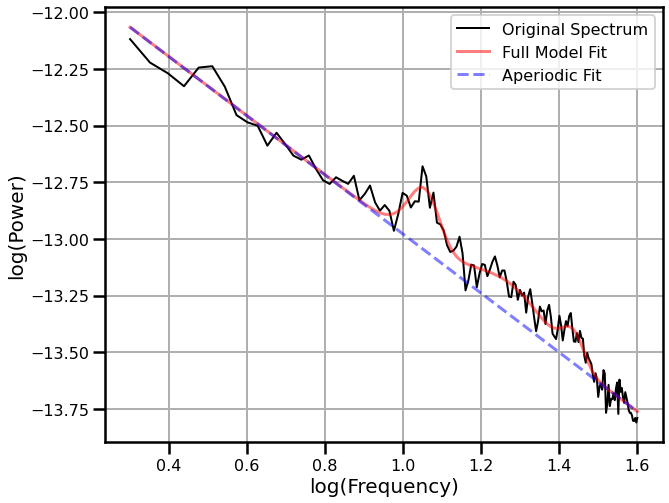

In [19]:
pd_model.plot(plt_log=True)

In [20]:
# inspect model fit of hc person
hc_model.print_settings(description=True)
print('r-squared: \t', hc_model.r_squared_)

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [2, 8]                                    
                        Limits for minimum and maximum peak widths, in Hz.                        
                                    Max Number of Peaks : inf                                     
                          Maximum number of peaks that can be extracted.                          
                                    Minimum Peak Height : 0.2                                     
                Minimum absolute height of a peak, above the aperiodic component.                 
                                       Peak Threshold: 2.0                                        
          

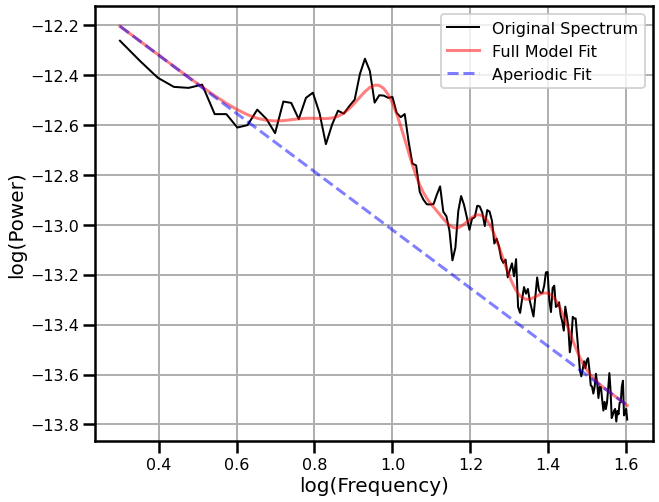

In [21]:
hc_model.plot(plt_log=True)

# Add plot including psd and aperiodic fit

### Interim Summary:
Now that we have visually inspected the model fit, and printed the r_squared values. We can see that the full model accurately fits original spectrum. Which means we can proceed to extract the aperiodic exponent and offset

## Step 5: Extract parameters of interest (exponent), and visualize

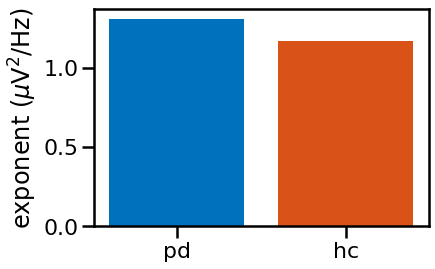

In [22]:
# we now extract the aperiodic components (offset, exponent)
pd_aperiodic = pd_model.aperiodic_params_
hc_aperiodic = hc_model.aperiodic_params_

plt.bar(['pd', 'hc'], [pd_aperiodic[1], hc_aperiodic[1]], color=['#0072BD', '#D95319'])
plt.ylabel('exponent ($\mu$V$^2$/Hz)')
plt.show()

Of course, this was only for 2 people from this dataset. The dataset has in total 16 Healthy Controls and 15 PD patients. 

So, let's see if we can use a for-loop to go over all of them, and instead of using a single model per person. We can apply FOOOFGroup to a 2D-array

# B. Now that we now what to do, perform spectral parameterization on full dataset

We will be using the same settings as before, so I'm not copying them

## Step 1: Import data & collect time signals of equal lengths

This includes extracting the sampling frequency, and doing a basic band-pass filter (since the data was not preprocessed)

In [23]:
# to suppress enormous mne output
mne.set_log_level(verbose='ERROR')

In [24]:
# Paths pointing to data (on a local laptop)
data_path = '/Users/quirine/Documents/Projects/parkinson_rest/DATA/'
sub_pd = 'sub-pd9/ses-off/eeg/sub-pd9_ses-off_task-rest_eeg.bdf'
sub_hc = 'sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf'

## For loop to gather power spectra

I prefer to use multiple for loops. One for creating the power spectra and saving those. Then, using that array as input for specparam. This means you can run a FOOOFGroup, which runs faster than individual FOOOF models in a for-loop since the Group can use parallel processing (by setting n_jobs to -1), which is really useful for larger data structures.

In [25]:
# First we need to figure out what the files are so we can load them
files = os.listdir(data_path)
files.sort()

# Create empty arrays for saving PSD data
pd_psd = np.full((15, len(freqs)), np.nan)
hc_psd = np.full((16, len(freqs)), np.nan)

# Create counters
pd_c = 0
hc_c = 0

for file in files:
    
    # if the file is not a subject folder file --> skip (such as README etc.)
    if file[:4] != 'sub-':
        continue

    # Load data
    if file[4:6] == 'hc':
        sub_path = file + '/ses-hc/eeg/sub-' + file[4:] + '_ses-hc_task-rest_eeg.bdf'
    else :
        sub_path = file + '/ses-off/eeg/sub-' + file[4:] + '_ses-off_task-rest_eeg.bdf'
        
    data = mne.io.read_raw_bdf(data_path + sub_path, preload=True)
    
    # Collect important meta-data
    FS = int(data_pd.info['sfreq']) # 512 Hz
    
    # Band-pass filter 1-40Hz
    data.filter(l_freq=1, h_freq=40)
    
    # Select only Cz electrode
    data_cz = data.get_data(picks='Cz').squeeze()

    # Cut signal down to 175 seconds
    sec = 175
    data_cz_cut = data_cz[:FS*sec]
    
    # Create PSD with 4 second windows, 
    freqs, psd = compute_spectrum(data_cz_cut, fs=FS, nperseg=FS*4, noverlap=FS*2, f_range=[1,40])
    
    # Save spectrum in 2D numpy array
    if file[4:6] == 'hc':
        hc_psd[hc_c,:] = psd
        hc_c += 1
    else :
        pd_psd[pd_c,:] = psd
        pd_c += 1



## Apply spectral parameterization

In [26]:
# Create models
pd_model = FOOOFGroup(**SETS_FOOOF)
hc_model = FOOOFGroup(**SETS_FOOOF)

# fit model
pd_model.fit(freqs, pd_psd, freq_range=FREQ_RANGE, n_jobs=-1)
hc_model.fit(freqs, hc_psd, freq_range=FREQ_RANGE, n_jobs=-1)

Running FOOOFGroup across 15 power spectra.
Running FOOOFGroup across 16 power spectra.


Now we should inspect whether the model fits the data appropriately

In [27]:
pd_model.print_results()

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 15                             
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

/Users/quirine/opt/anaconda3/lib/python3.8/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


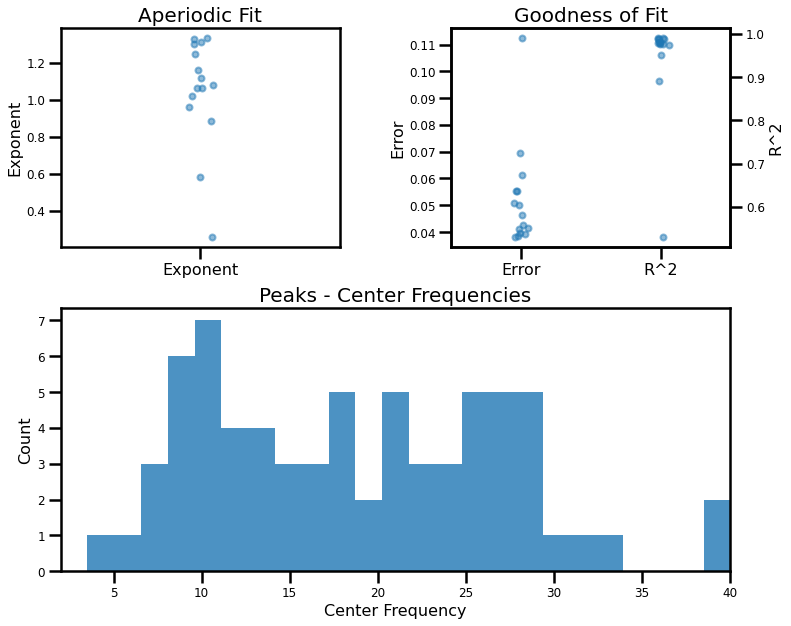

In [28]:
pd_model.plot()

If we look at the distribution of Rˆ2, it actually looks pretty good. It seems like there is just 1 spectrum with a poor fit. Perhaps this is the same person as the dot with a high error (another metric for evaluating model fit).

Think about what we should do after finding such a finding?

In [29]:
hc_model.print_results()

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 16                             
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

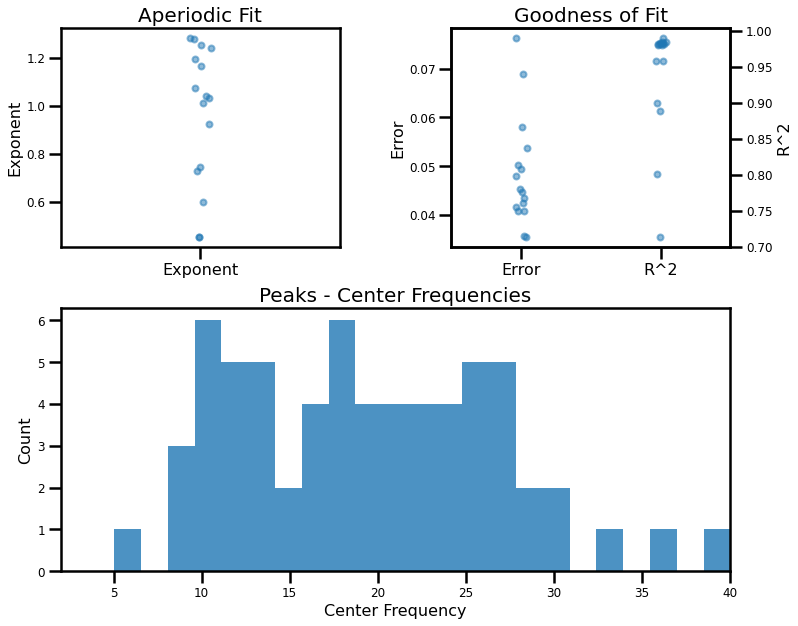

In [30]:
hc_model.plot()

So, this is where you would set a threshold for an acceptible Rˆ2 value. In this case, I'm gonna go ahead and say our cut-off is at 0.8. Anything below that, we should eliminate from further analyses. Keep in mind that if you run spectral parameterization on single trial data, you probably want to consider a different approach for under- and over-fitting. Which will be discussed in another notebook.

## Inspect and delete bad fits from data

### First we need to extract all our parameters of interest

In [31]:
# Extract aperiodic exponent - pd
pd_exps = pd_model.get_params('aperiodic_params', 'exponent')

# Extract goodness-of-fit metrics - pd
pd_errors = pd_model.get_params('error')
pd_r2s = pd_model.get_params('r_squared')

# Extract aperiodic exponent - hc
hc_exps = hc_model.get_params('aperiodic_params', 'exponent')

# Extract goodness-of-fit metrics - hc
hc_errors = hc_model.get_params('error')
hc_r2s = hc_model.get_params('r_squared')

In [32]:
# Now we should get the indexes that we need to remove from the other parameters as well
pd_to_delete = np.where(pd_r2s < 0.8)
hc_to_delete = np.where(hc_r2s < 0.8)

# Delete those aperiodic fits from our data
pd_exps = np.delete(pd_exps, pd_to_delete)
hc_exps = np.delete(hc_exps, hc_to_delete)

### Now, we will visualize the bad fits to make sure they should be deleted

In [33]:
# Extract a single fit from a FOOOFGroup
pd_bad = pd_model.get_fooof(ind=pd_to_delete[0][0], regenerate=True)

In [34]:
pd_bad.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -12.3934, 0.2571                                         
                                                                                                  
                                       5 peaks were found:                                        
          

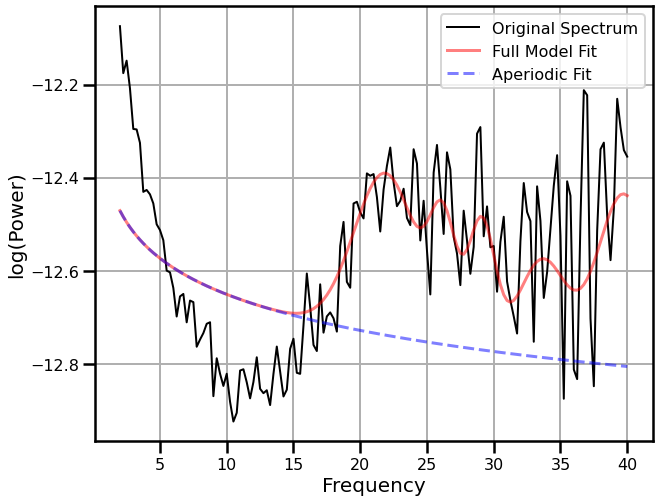

In [35]:
pd_bad.plot()

That indeed looks like a strange power spectrum

In [36]:
# Extract a single fit from a FOOOFGroup
hc_bad = hc_model.get_fooof(ind=hc_to_delete[0][0], regenerate=True)

In [37]:
hc_bad.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -12.4165, 0.4525                                         
                                                                                                  
                                       5 peaks were found:                                        
          

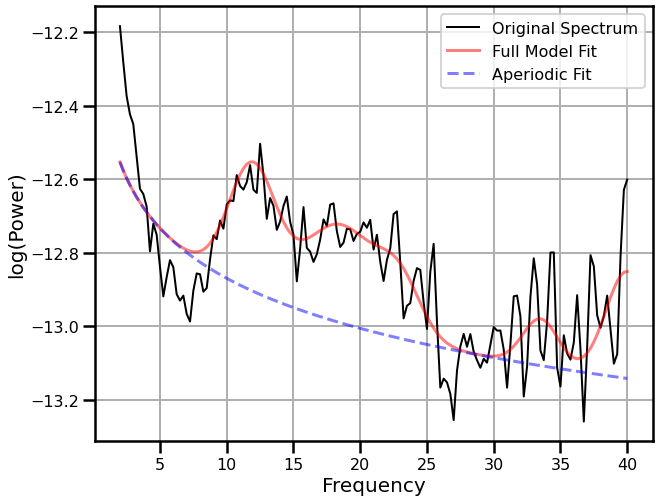

In [38]:
hc_bad.plot()

## Now we know what a bad fits looks like. Let's just check what a good fit looks like for our own sanity

In [39]:
# Get indices of best model fits
pd_good_idx = pd_r2s.argmax()
hc_good_idx = hc_r2s.argmax()

In [40]:
# Extract a single fit from a FOOOFGroup
pd_good = pd_model.get_fooof(ind=pd_good_idx, regenerate=True)

In [41]:
pd_good.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.4071, 1.2457                                         
                                                                                                  
                                       5 peaks were found:                                        
          

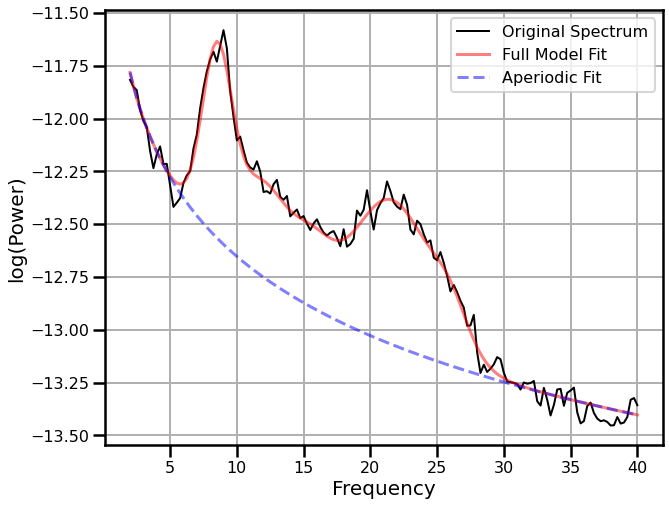

In [42]:
pd_good.plot()

In [43]:
# Extract a single fit from a FOOOFGroup
hc_good = pd_model.get_fooof(ind=hc_good_idx, regenerate=True)

In [44]:
hc_good.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.9511, 1.1173                                         
                                                                                                  
                                       7 peaks were found:                                        
          

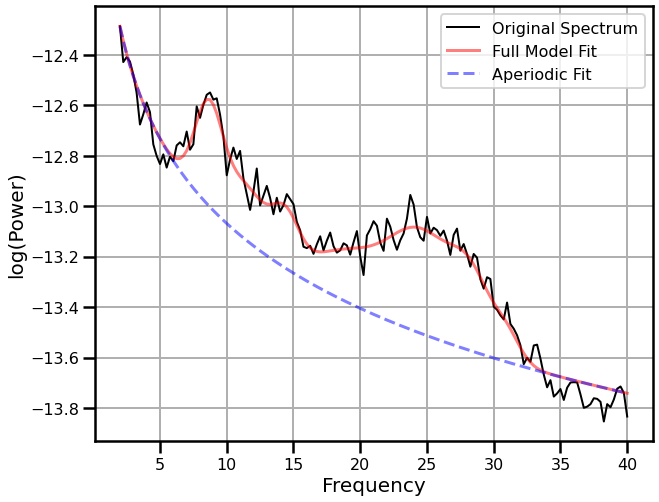

In [45]:
hc_good.plot()

So, you can see that that the difference between a good and a bad fit is mostly due to the noisyness of the PSD, not necessary the model being bad

## Statistics & data visuzlization

For the statistics:
- Between group design
- Independent variable = Parkinson's Disease or Healthy Control
- Dependent variable = aperiodic exponent

Thus, we need a t-test, as long as the variances are the same, and the data is normally distributed


For the visualization, a barplot is the most standard in this case

### Visualize data using a barplot

In [46]:
# For the visualization I prefer to use seaborn instead of matplotlib, 
# which means data needs to be converted into a pandas dataframe
df_dict_pd = {'group': np.repeat('pd', len(pd_exps)),
             'exp': pd_exps}
df_pd = pd.DataFrame(data=df_dict_pd)
df_dict_hc = {'group': np.repeat('hc', len(hc_exps)),
             'exp': hc_exps}
df_hc = pd.DataFrame(data=df_dict_hc)

# Create a long style dataframe by concatenating
df_data = pd.concat([df_pd, df_hc], axis=0)

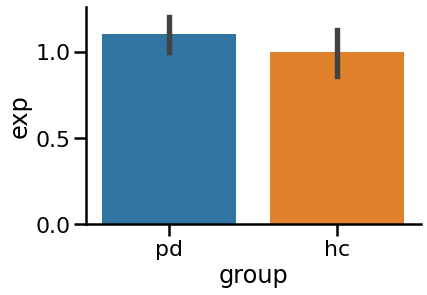

In [47]:
# Now we can use seaborn to plot the data, average exponents, with a default of 95% Confidence Interval
sns.barplot(data=df_data, x='group', y='exp')
sns.despine()
plt.show()

### Now we're ready for some stats

In [48]:
# Check normality
pg.normality(data=df_data, dv='exp', group='group')

,W,pval,normal
pd,0.897501,0.103752,True
hc,0.899191,0.092504,True


Both groups have a normal data distribution

In [49]:
# Check if equal variance between groups
pg.homoscedasticity(data=df_data, dv='exp', group='group')

,W,pval,equal_var
levene,0.728322,0.400936,True


Cool, we also have equal variance, so we can proceed with a parametric t-test

In [50]:
# do t-test or unparameteric version of a t-test
pd = df_data.query('group=="pd"')['exp']
hc = df_data.query('group=="hc"')['exp']
pg.ttest(pd, hc, paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.178608,26.306633,two-sided,0.249105,"[-0.08, 0.28]",0.434364,0.586,0.203605


### Conclusion

<>

So with resting state, you can extend it to different clinical populations, age (young vs old), gender (?)

So, at rest there are population differences, but what about diseases that have more functional differences. How can we inspect aperiodic (exponent) differences in event-related experiments?


# Next notebook: 

Resting state might not be uniform --> dynamic changes are possible.

Dynamic changes definitely happen in event-related data, therefore, how you create PSD is even more important.

Other notebooks:
- Multitaper vs other methods for creating PSD
- Event-related aperiodic analysis
- Time-resolved event-related analysis (sliding window approach)